In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'       #Disactivate multiprocessing for numpy
import numpy as np
import matplotlib.pyplot as plt
import json
import gymnasium as gym
import yaml
from datetime import datetime

import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, CheckpointCallback, StopTrainingOnNoModelImprovement

from sogym.env import sogym
from sogym.mmc_optim import run_mmc
from sogym.env import sogym
from sogym.expert_generation import generate_expert_dataset, generate_mmc_solutions, generate_dataset
from sogym.utils import profile_and_analyze,ImageDictExtractor, CustomBoxDense
from sogym.callbacks import FigureRecorderCallback, MaxRewardCallback, GradientNormCallback, GradientClippingCallback
from sogym.pretraining import pretrain_agent, ExpertDataSet

import torch
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, Dataset

%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 2.2.1
Using device: cuda


---
### Environment test and visualization:

In [2]:
# Let's test the environment using the check_env util from SB3:
observation_type = 'topopt_game'
train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity = True)
eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=False)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
obs,info=train_env.reset()
dones = False
#use deepcopy to save 
while dones== False:
    action = train_env.action_space.sample()
    print(action)
    obs, rewards, dones,truncated, info = train_env.step(action)
    print(rewards)
train_env.plot()

In [ ]:
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='topopt_game'))

In [ ]:
# Example usage
# Specify the number of episodes to run
num_episodes = 20
# Call the profile_and_analyze function
result_df = profile_and_analyze(num_episodes, train_env)
# Print the resulting DataFrame
result_df

In [ ]:
obs = train_env.reset()
cfg = {
            'optimizer':'mma', #optimiser choice
            'xInt':0.25, #initial interval of components in x
            'yInt':0.25, #initial interval of components in y
            'E':1.0, #Young's modulus
            'nu':0.3, #Poisson ratio
            'h':1, #thickness
            'dgt0':5, #significant digit of sens.
            'scl':1, #scale factor for obj
            'p':6,  #power of super ellipsoid
            'lmd':100, #power of KS aggregation   
            'maxiter':500, # maximum number of outer iterations
            'alpha':1e-9, # This is the threshold level in the Heaviside function
            'epsilon':0.2, #This is the regularization term in the Heaviside function
            'maxinnerinit':1, # This is the maximum number of inner iterations for GCMMA
            'switch':-0.000002, # This is the switch criteria for the hybrid optimizer
            'convergence_threshold':2e-4, #This is the threshold for the relative change in the objective function
            'xmin':(0.0, 0.0, 0.0, 0.00, 0.00, -np.pi),
            'xmax':(train_env.dx, train_env.dy, 0.7*min(train_env.dx,train_env.dy), 0.05*min(train_env.dx,train_env.dy),0.05*min(train_env.dx,train_env.dy), np.pi)
        }

#run_mmc(train_env.conditions,train_env.nelx,train_env.nely,train_env.dx,train_env.dy,plotting='contour',verbose=0,cfg=cfg)
dataset_folder = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
#generate_mmc_solutions(key=0,dataset_folder="/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc")
generate_dataset(dataset_folder= dataset_folder, num_threads=32, num_samples=20000)

In [ ]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done,truncated, info = train_env.step(action)
        
# print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [ ]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

# Initialize the index for the current subplot
subplot_index = 0

# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward == 0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, truncated, info = train_env.step(action)
        
        # Plot the current observation image
        axes[subplot_index].imshow(obs['strain_energy'].T, cmap='gray')
        axes[subplot_index].axis('off')
        axes[subplot_index].set_title(f"Timestep {subplot_index+1}")
        
        # Increment the subplot index
        subplot_index += 1
        
        # If all subplots are filled, display the plot and reset the index
        if subplot_index == len(axes):
            plt.tight_layout()
            plt.show()
            subplot_index = 0

# Print the reward
print("Reward:", reward)

# Plot the final state of the training environment
train_env.plot()

# Display any remaining subplots
if subplot_index > 0:
    for i in range(subplot_index, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [77]:
# Specify the number of permutations to generate
num_permutations = None
observation_type = "topopt_game"

# Specify the environment configuration (optional)
env_kwargs = {
    'mode': 'train',
    'observation_type': observation_type,
    'vol_constraint_type': 'hard',
    'seed': 42,
    'resolution' : 50,
    'check_connectivity':True
}

directory_path = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
expert_observations, expert_actions = generate_expert_dataset(directory_path,env_kwargs, plot_terminated=False,num_permutations = num_permutations, file_fraction=1.0)
# Save the dataset
import pickle

# Save the data using pickle
with open('expert_dataset_topopt_noperm.pkl', 'wb') as f:
    pickle.dump({'expert_observations': expert_observations, 'expert_actions': expert_actions}, f, protocol=4)
print(len(expert_observations))

Processing files: 100%|█████████▉| 40469/40602 [27:22<00:08, 16.31file/s]


7


<Figure size 640x480 with 0 Axes>

In [3]:
import pickle

# Load the data using pickle
with open('expert_dataset_topopt_noperm.pkl', 'rb') as f:
    data = pickle.load(f)

expert_observations = data['expert_observations']
expert_actions = data['expert_actions']

tensor([-0.3917,  0.2451,  0.8290, -1.0000,  0.9998,  1.0000],
       dtype=torch.float64)


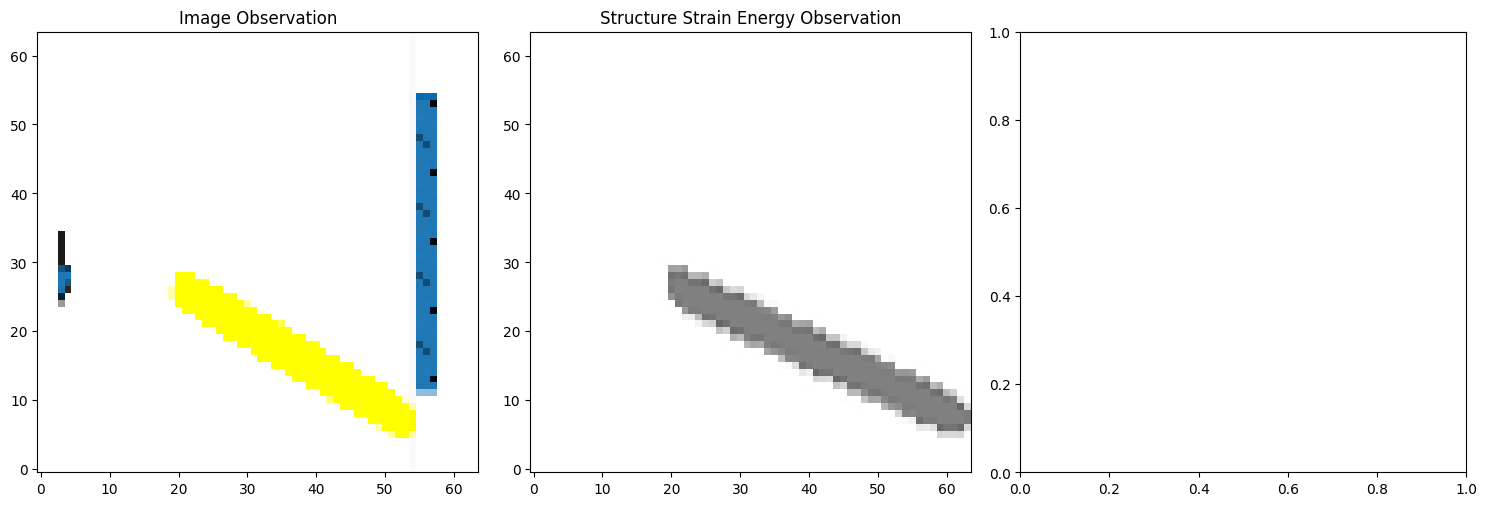

In [14]:
# Assuming you have the expert_dataset defined
expert_dataset = ExpertDataSet(expert_observations, expert_actions, train_env)
# Get a random sample from the dataset
sample_idx = np.random.randint(len(expert_dataset))
sample = expert_dataset[sample_idx]

# Extract the observation and reward from the sample
observation, action = sample

# Subplot with image, strain_energy, and structure_strain_energy observations:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot image observation
axes[0].imshow(observation['image'].T, cmap='gray', origin='lower')
axes[0].axis('on')
axes[0].set_title("Image Observation")

# Plot strain_energy observation
axes[1].imshow(observation['structure_strain_energy'].T, origin='lower')
axes[1].axis('on')
axes[1].set_title("Structure Strain Energy Observation")

print(action)
plt.tight_layout()
plt.show()

In [79]:
obs = train_env.reset()

#use action and plot the result
obs, rewards, dones,truncated, info = train_env.step(np.array(action))

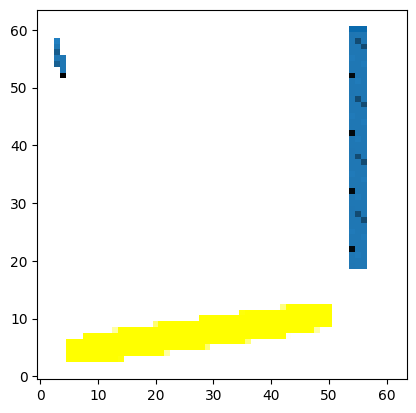

In [80]:
plt.imshow(obs['image'].T,origin='lower')

In [15]:
chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' or observation_type == 'topopt_game' else CustomBoxDense

# Load the YAML file
env=train_env

with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch'],
    share_features_extractor = False
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 1024, but because the `RolloutBuffer` is of size `n_steps * n_envs = 64`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 64
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=64 and n_envs=1)
  warnings.warn(


In [16]:
from torchinfo import summary
total_params = sum(p.numel() for p in model.policy.parameters())
print(f"Total number of parameters: {total_params:,}")
data = {k: v for k, v in observation.items()}
# Assuming you have a PyTorch model named 'model' and the input size is (3, 224, 224)
summary(model.policy)


Total number of parameters: 18,875,917


Layer (type:depth-idx)                   Param #
MultiInputActorCriticPolicy              6
├─ImageDictExtractor: 1-1                --
│    └─ReLU: 2-1                         --
│    └─ModuleDict: 2-2                   --
│    │    └─Sequential: 3-1              22,784
│    │    └─Sequential: 3-2              93,248
│    │    └─Sequential: 3-3              16,768
│    │    └─Sequential: 3-4              16,768
│    │    └─Sequential: 3-5              93,248
│    │    └─Sequential: 3-6              16,768
├─ImageDictExtractor: 1-2                (recursive)
│    └─ReLU: 2-3                         --
│    └─ModuleDict: 2-4                   (recursive)
│    │    └─Sequential: 3-7              (recursive)
│    │    └─Sequential: 3-8              (recursive)
│    │    └─Sequential: 3-9              (recursive)
│    │    └─Sequential: 3-10             (recursive)
│    │    └─Sequential: 3-11             (recursive)
│    │    └─Sequential: 3-12             (recursive)
├─ImageDictExtractor

2024-04-12 14:04:19.907945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:04:20.439075: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/cv2/../../lib64:/local/cuda-11.3/lib64:/local/TensorRT-7.2.2.3/lib
2024-04-12 14:04:20.439211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

Train Epoch: 1 [4096/259852 (2%)]	Loss: 1.542861	Grad Norm: 4.901312	LR: 1.000000
Train Epoch: 1 [24576/259852 (9%)]	Loss: 1.594207	Grad Norm: 7.205245	LR: 1.000000
Train Epoch: 1 [45056/259852 (17%)]	Loss: 2.338184	Grad Norm: 9.999999	LR: 1.000000
Train Epoch: 1 [65536/259852 (25%)]	Loss: 1.828519	Grad Norm: 10.000000	LR: 1.000000
Train Epoch: 1 [86016/259852 (33%)]	Loss: 2.163317	Grad Norm: 9.999999	LR: 1.000000
Train Epoch: 1 [106496/259852 (41%)]	Loss: 1.673116	Grad Norm: 8.843509	LR: 1.000000
Train Epoch: 1 [126976/259852 (48%)]	Loss: 2.012176	Grad Norm: 10.000000	LR: 1.000000
Train Epoch: 1 [147456/259852 (56%)]	Loss: 1.757353	Grad Norm: 9.999999	LR: 1.000000
Train Epoch: 1 [167936/259852 (64%)]	Loss: 1.932213	Grad Norm: 9.999999	LR: 1.000000
Train Epoch: 1 [188416/259852 (72%)]	Loss: 1.534308	Grad Norm: 8.438760	LR: 1.000000
Train Epoch: 1 [208896/259852 (80%)]	Loss: 1.725425	Grad Norm: 9.999999	LR: 1.000000
Train Epoch: 1 [229376/259852 (88%)]	Loss: 1.487565	Grad Norm: 8.014029

/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Epoch 5: Mean reward = 0.044 +/- 0.001
Train Epoch: 6 [4096/259852 (2%)]	Loss: 1.499727	Grad Norm: 10.000001	LR: 0.903921
Train Epoch: 6 [24576/259852 (9%)]	Loss: 1.274030	Grad Norm: 9.999998	LR: 0.903921
Train Epoch: 6 [45056/259852 (17%)]	Loss: 1.387603	Grad Norm: 9.999999	LR: 0.903921
Train Epoch: 6 [65536/259852 (25%)]	Loss: 1.361368	Grad Norm: 9.999999	LR: 0.903921
Train Epoch: 6 [86016/259852 (33%)]	Loss: 1.205142	Grad Norm: 9.999999	LR: 0.903921
Train Epoch: 6 [106496/259852 (41%)]	Loss: 1.556188	Grad Norm: 9.999998	LR: 0.903921
Train Epoch: 6 [126976/259852 (48%)]	Loss: 1.142905	Grad Norm: 9.999998	LR: 0.903921
Train Epoch: 6 [147456/259852 (56%)]	Loss: 1.232325	Grad Norm: 10.000000	LR: 0.903921
Train Epoch: 6 [167936/259852 (64%)]	Loss: 1.120810	Grad Norm: 9.956255	LR: 0.903921
Train Epoch: 6 [188416/259852 (72%)]	Loss: 1.144179	Grad Norm: 10.000000	LR: 0.903921
Train Epoch: 6 [208896/259852 (80%)]	Loss: 1.210618	Grad Norm: 9.999999	LR: 0.903921
Train Epoch: 6 [229376/259852 (

KeyboardInterrupt: 

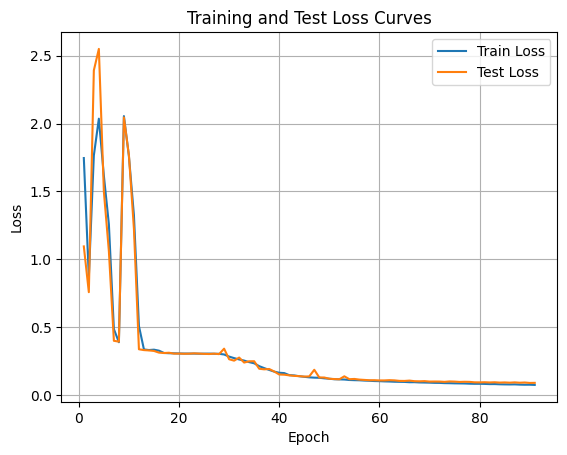

In [17]:
pretrain_agent(
    model,
    expert_observations,
    expert_actions,
    env,
    test_env = eval_env,
    batch_size=4096,
    epochs=500,
    scheduler_gamma=0.98,
    learning_rate=1.0,
    log_interval=5,
    no_cuda=False,
    seed=1,
    verbose=True,
    test_batch_size=512,
    early_stopping_patience=300,
    plot_curves=True,
    tensorboard_log_dir="tb_logs/imitation",
    save_path="checkpoints/imitation_PPO",
    comet_ml_api_key="No20MKxPKu7vWLOUQCFBRO8mo",
    comet_ml_project_name="pretraining_rl",
    comet_ml_experiment_name="PPO_1",
    eval_freq = 5,
    l2_reg_strength=0.0000,
)

---
### Multiprocessing

In [38]:
#from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
import multiprocessing

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')

# Set number of cpus to use automatically:
num_cpu = multiprocessing.cpu_count()
print("Using {} cpus!".format(num_cpu))
observation_type = "topopt_game"

train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type = 'hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


Using 64 cpus!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

--- 
### Defining the model

In [39]:
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.5 * np.ones(n_actions))

chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' or observation_type=="topopt_game" else CustomBoxDense

# Load the YAML file

with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch'],
    share_features_extractor = False,
)
# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                #action_noise = action_noise,
                ent_coef = 0.0,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

In [40]:
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=50000//num_cpu,
  save_path="./checkpoints/",
  name_prefix=tb_log_name,
  save_replay_buffer=True,
  save_vecnormalize=True,
)

eval_callback = EvalCallback(eval_env,
                             log_path='tb_logs',
                             eval_freq=5000//num_cpu,
                             deterministic=True,
                            n_eval_episodes=10,
                             render=False,
                             best_model_save_path='./checkpoints',
                             verbose=0)

callback_list = CallbackList([eval_callback,
                         checkpoint_callback,
                         MaxRewardCallback(verbose=1),
                         GradientClippingCallback(clip_value=1.0, verbose=1),
                         GradientNormCallback(verbose=1),
                         FigureRecorderCallback(check_freq=5000//num_cpu,eval_env=eval_env),
                         StopTrainingOnNoModelImprovement(max_no_improvement_evals=50, min_evals=100, verbose=1)
                         ])

--- 
### Training

Save the model:

If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

If the environment is normalized:
#env.save('env_saved.pkl')
#env = VecNormalize.load('env_saved.pkl',env)


In [41]:

import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            
#model = SAC.load("checkpoints/imitation_SAC",env =env) 
model.set_parameters("checkpoints/imitation_PPO.zip")
model.set_parameters("imitation_PPO_critic")

train_critic_only = False
if train_critic_only:
    #Freeze everything:
    for name, param in model.policy.named_parameters():
        if param.requires_grad:
            param.requires_grad=False

    if algorithm_name =='SAC'
        # Unfreeze critic:
        for param in model.policy.critic.parameters():
            if param.requires_grad==False:
                param.requires_grad=True

        for param in model.policy.critic_target.parameters():
            if param.requires_grad==False:
                param.requires_grad=True
        
        #Reset critic networks:
        if hasattr(model.policy.critic_target, 'reset_parameters'):
            print(' resetting')
            model.policy.critic_target.reset_parameters()
        else:
            model.policy.critic_target.apply(init_weights)

            
        if hasattr(model.policy.critic, 'reset_parameters'):
            print('resetting')
            model.policy.critic_target.reset_parameters() 
        else:
            model.policy.critic.apply(init_weights)


    if algorithm_name == 'PPO':
        for param in model.policy.mlp_extractor.value_net.parameters():
            if param.requires_grad==False:
                param.requires_grad=True
            
        for param in model.policy.value_net.parameters():
            if param.requires_grad==False:
                param.requires_grad=True
        

        if hasattr(model.policy.value_net, 'reset_parameters'):
            print(' resetting')
            model.policy.value_net.reset_parameters()
        else:
            model.policy.value_net.apply(init_weights)
            
        if hasattr(model.policy.mlp_extractor.value_net, 'reset_parameters'):
            print(' resetting')
            model.policy.mlp_extractor.value_net.reset_parameters() 
        else:
            model.policy.mlp_extractor.value_net.apply(init_weights)

In [42]:

#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
model.learn(20000000,
            callback=callback_list, 
            tb_log_name=tb_log_name
            )
#model.save('model_saved_march15',)
#model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_check_nan.VecCheckNan object at 0x7fc140458340> != <stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fbc2204fee0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward` for environment variables or `env.get_wrapper_attr('reward')` that will search the reminding wrappers.
  logger.warn(
/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward to get variables from other wrappers is deprecat

KeyboardInterrupt: 

In [27]:
model.save('checkpoints/imitation_PPO_critic')

---
### Let's visualize the agent's performance:

In [ ]:
env=sogym(mode='train',observation_type='image',vol_constraint_type='hard' ,resolution = 50)
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

[-0.96462613 -0.99048704  0.38009977  0.08957338  0.9785042   0.96510744]
[-0.57749254  0.55976856 -0.8036035  -0.97631305  0.4027611   0.51337385]
[-0.63751614 -0.5484587  -0.68173546  0.99026537  0.60249984  0.7280123 ]
[-0.7092295   0.9814949   0.23871887 -0.2769655   0.8502177   0.86372375]
[-0.44792038 -0.94188035  0.49378872  0.09349489  0.5592005   0.39041722]
[-0.27786326 -0.2657057   0.4812293   0.17316115  0.08975875 -0.43019438]
[ 0.2240442  -0.05230045  0.78103995  0.9819428   0.7970079   0.7638916 ]
[ 0.83928895  0.9800999   0.31479597 -0.41921186  0.8269007   0.76901615]
Desired volume: 0.49 Obtained volume: 0.3428822942241449
Env reward: 0.2637187488365308


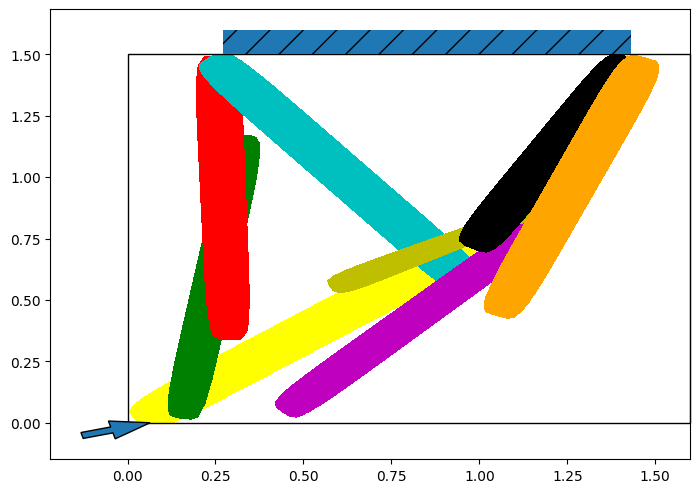

In [86]:
obs,info=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones,truncated, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
print("Env reward:",rewards)
env.plot()

In [ ]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')